In [ ]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

In [ ]:
!wget http://upscfever.com/datasets/flowers-new.zip -P drive/app
import os
os.chdir('drive/app')  #change dir
!unzip -q flowers-new.zip  #unzip data in test/

--2020-12-11 13:23:36--  http://upscfever.com/datasets/flowers-new.zip
Resolving upscfever.com (upscfever.com)... 104.27.176.133, 104.27.177.133, 172.67.193.2, ...
Connecting to upscfever.com (upscfever.com)|104.27.176.133|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://upscfever.com/datasets/flowers-new.zip [following]
--2020-12-11 13:23:37--  https://upscfever.com/datasets/flowers-new.zip
Connecting to upscfever.com (upscfever.com)|104.27.176.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘drive/app/flowers-new.zip’

flowers-new.zip         [         <=>        ]   5.74M  2.33MB/s    in 2.5s    

2020-12-11 13:23:41 (2.33 MB/s) - ‘drive/app/flowers-new.zip’ saved [6021364]



In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR='/content/gdrive/MyDrive/Flowers/daisy'
FLOWER_SUNFLOWER_DIR='/content/gdrive/MyDrive/Flowers/sunflower'
FLOWER_TULIP_DIR='/content/gdrive/MyDrive/Flowers/tulip'
FLOWER_DANDI_DIR='/content/gdrive/MyDrive/Flowers/dandelion'
FLOWER_ROSE_DIR='/content/gdrive/MyDrive/Flowers/rose'

In [ ]:
def assign_label(img,flower_type):
    return flower_type

In [ ]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

In [ ]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

FileNotFoundError: ignored

In [ ]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

In [ ]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

In [ ]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

In [ ]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

In [ ]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()

In [ ]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

In [ ]:
X.shape

In [ ]:
Y.shape

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25)

In [ ]:
y_test.shape

In [ ]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

In [ ]:
#using a LR Annealer
batch_size=128
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [ ]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test), 
                              verbose = 1)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

In [ ]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions,axis = 1)

In [ ]:
y_test_ = to_categorical(y_test)

In [ ]:
predictions = to_categorical(predictions,5)

In [ ]:
a = np.argmax(predictions, axis=1 )

In [ ]:
b = np.argmax(y_test ,axis=1)

In [ ]:
cm = confusion_matrix(a,b)
cm

In [ ]:
accuracy = sum(cm[i][i] for i in range(5)) / y_test.shape[0]
print("accuracy = " + str(accuracy))

Screenshot of accuracy

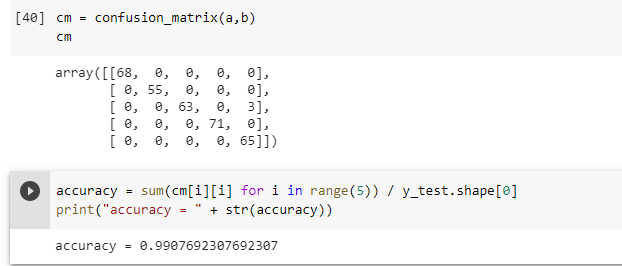

In [ ]:
from sklearn.metrics import precision_score, recall_score
print('precision score - ',precision_score(y_test, predictions, average="macro"))
print('recall score - ', recall_score(y_test, predictions, average="macro"))

In [ ]:
model.save('final_flowers_model2')

In [ ]:
from tensorflow import keras
model = keras.models.load_model('final_flowers_model2')